# Problem : Linear Calibration (Thermometer)

- **Task:** Map “unknown-scale” readings $t_u$ to true Celsius $t_c$ using a linear model.

$$
t_p = w\, t_u + b
$$

- **Interpretation:**
  - $w$: gain/scale (stretch/squeeze)
  - $b$: offset/bias (systematic shift)
- **Why linear?** Sensors are often approximately affine over normal ranges.
- **Goal:** Find $w,b$ that make predictions $t_p$ close to targets $t_c$ using mnnaually coded loss, gradient functions.


# Imports

In [72]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

print(sys.version)
print(torch.__version__)
print(np.__version__)

3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:28:53) [Clang 19.1.7 ]
2.8.0
2.3.4


# Dataset

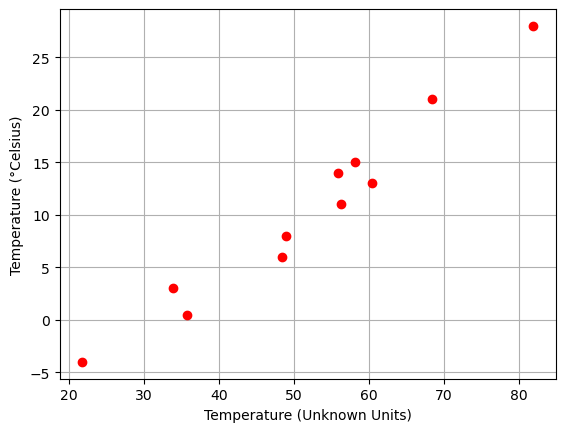

In [73]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])

plt.grid(True)
plt.plot(t_u.numpy(), t_c.numpy(), 'o', color='red')
plt.xlabel('Temperature (Unknown Units)')
plt.ylabel('Temperature (°Celsius)')
plt.show()

# Nonmalization

In [74]:
normalization_factor = 0.1

In [75]:
t_u *= normalization_factor
t_c *= normalization_factor

# Model
Simple linear model  
$y = w \times x + b$




In [76]:
def model(x, w, b):
    return w * x + b

# Loss Function - Mean Squared Error


$$
L(yp,y)=\frac{1}{N}\sum_{i=1}^{N}\Big(yp^{(i)}-y^{(i)}\Big)^2
$$

&emsp;&emsp;&emsp;yp : Predicted values.<br>
&emsp;&emsp;&emsp;y  : Acutal Values.

- **Intuition:** One scalar measures fit quality (smaller is better). Squaring emphasizes large errors and keeps derivatives smooth.
- **Sanity checks:** Evaluate loss for multiple $(w,b)$ guesses to confirm expected behavior.


In [77]:
def loss_fn(yp, y):
    squared_diffs = (yp - y)**2
    return squared_diffs.mean()

# Backword Propogation Gradients


- **Idea:** Approximate sensitivity of the loss with tiny nudges $\delta$ (central differences):

$$
\frac{\partial L}{\partial w}\approx\frac{L(w+\delta,b)-L(w-\delta,b)}{2\delta},\quad
\frac{\partial L}{\partial b}\approx\frac{L(w,b+\delta)-L(w,b-\delta)}{2\delta}
$$

- **Pros:** Simple, model-agnostic, great for gradient debugging.
- **Cons:** Extra loss evaluations; $\delta$ must be chosen carefully (too big → bias; too small → floating-point noise).


In [78]:
def dmodel_dw(x, w, b):
    return x

In [79]:
def dmodel_db(x, w, b):
    return 1.0

# Analytical Gradients

**Model & variables used in code**
- Prediction: **`yp = w * x + b`**
- Target: **`y`**
- Residual (error): **`e = yp - y`**
- Loss (MSE, mean reduction):  
  $$
  L \;=\; \frac{1}{N}\sum_{i=1}^{N}(yp^{(i)} - y^{(i)})^2 \;
  $$

**Gradient wrt predictions (matches `dloss_fn`)**
- Using MSE with **mean**:
  $$
  \frac{\partial L}{\partial yp} \;=\; \frac{2}{N}\sum_{i=1}^{N}(yp^{(i)}- y^{(i)}) \;
  $$


In [80]:
def dloss_fn(yp, y):
    dsq_diffs = 2 * (yp - y) / yp.size(0)
    return dsq_diffs

In [81]:
def grad_fn(x, y, yp, w, b):
    dloss_dtp = dloss_fn(yp, y)
    dloss_dw = dloss_dtp * dmodel_dw(x, w, b)
    dloss_db = dloss_dtp * dmodel_db(x, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

# Manual Gradient Descent Training Loop (No Autograd)

- **Update rule:**

$$
w \leftarrow w - \eta\,\frac{\partial L}{\partial w},\qquad
b \leftarrow b - \eta\,\frac{\partial L}{\partial b}
$$

- **Loop steps per epoch:**
  1. Forward: $yp = w\,x + b$
  2. Compute $L$ (MSE)
  3. Compute gradients (analytical)
  4. Update $w,b$ with learning rate $\eta$
  5. Track $L$ over epochs

- **Expected behavior:** Loss generally decreases; use plots to diagnose issues.


In [82]:
def training_loop(n_epochs, learning_rate, params, x, y,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        yp = model(x, w, b)
        loss = loss_fn(yp, y)
        grad = grad_fn(x, y, yp, w, b)

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>

    return params

In [83]:
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    x = t_u,
    y = t_c,
    print_params = True)
params

Epoch 1, Loss 17.638847
    Params: tensor([ 0.5483, -0.0826])
    Grad:   tensor([45.1730,  8.2600])
Epoch 2, Loss 2.944970
    Params: tensor([ 0.3708, -0.1167])
    Grad:   tensor([17.7483,  3.4149])
Epoch 3, Loss 0.668645
    Params: tensor([ 0.3012, -0.1318])
    Grad:   tensor([6.9557, 1.5079])
...
Epoch 10, Loss 0.246408
    Params: tensor([ 0.2592, -0.1587])
    Grad:   tensor([-0.0370,  0.2693])
Epoch 11, Loss 0.245671
    Params: tensor([ 0.2596, -0.1613])
    Grad:   tensor([-0.0431,  0.2677])
...
Epoch 99, Loss 0.189708
    Params: tensor([ 0.2981, -0.3794])
    Grad:   tensor([-0.0406,  0.2299])
Epoch 100, Loss 0.189163
    Params: tensor([ 0.2985, -0.3817])
    Grad:   tensor([-0.0405,  0.2295])
...
Epoch 4000, Loss 0.029277
    Params: tensor([ 0.5365, -1.7287])
    Grad:   tensor([-5.4553e-05,  3.0266e-04])
Epoch 5000, Loss 0.029276
    Params: tensor([ 0.5367, -1.7302])
    Grad:   tensor([-1.0915e-05,  5.5291e-05])


tensor([ 0.5367, -1.7302])

# Scaling both $X$ and $Y$ by $s$ — effect on $w$ and $b$ (example: $s=0.1$)

**Original variables and model**
- Input: $X$
- Target: $Y$
- True model: $Y = aX + b$

**Scaled variables (with $s=0.1$ as an example)**
- $x = sX$
- $y = sY$

**Training in scaled space**
$$
y = wx + b_{\text{scaled}}.
$$

**Substitute back to original units** (since $y=sY$ and $x=sX$)
$$
sY = w(sX) + b_{\text{scaled}}
\Rightarrow
Y = wX + \frac{b_{\text{scaled}}}{s}.
$$

**Key result (when input *and* target are both scaled by the same $s$)**
- Slope: $w_{\text{original}} = w_{\text{scaled}}$  *(unchanged)*
- Intercept: $b_{\text{original}} = \frac{b_{\text{scaled}}}{s}$

---

## Mapping learned parameters back to original units (example $s=0.1$)
If training on $(x, y)$ yields $(w_{\text{learn}}, b_{\text{learn}})$, then
$$
w_{\text{orig}} = w_{\text{learn}}, \qquad
b_{\text{orig}} = \frac{b_{\text{learn}}}{s} \;=\; 10\,b_{\text{learn}}.
$$

---

## Cheat sheet

| What you scaled                     | Training model     | Map **back** to original units |
|---|---|---|
| Input only: $x=sX$                 | $Y = wx + b$       | $w_{\text{orig}} = ws,\; b_{\text{orig}} = b$ |
| Target only: $y=sY$                | $y = wX + b$       | $w_{\text{orig}} = \frac{w}{s},\; b_{\text{orig}} = \frac{b}{s}$ |
| Input & Target: $x=sX,\; y=sY$     | $y = wx + b$       | $w_{\text{orig}} = w,\; b_{\text{orig}} = \frac{b}{s}$ ✅ |


so the final Params b need be scaled, after scaling the value should be close to

$C = 0.5555556 * F − 17.777778$


In [84]:
w = params[0]
b = params[1] / normalization_factor
w, b

(tensor(0.5367), tensor(-17.3015))

# Output

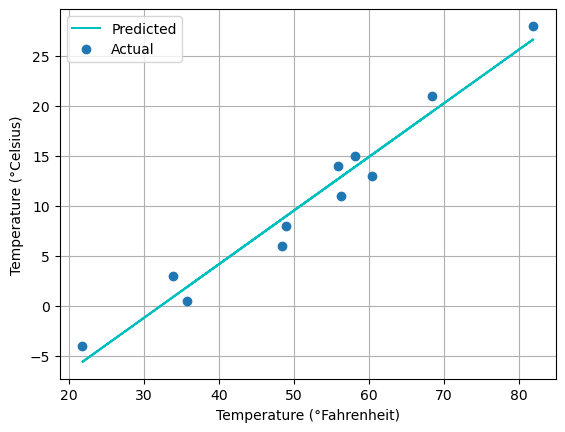

In [85]:
t_p = model(t_u, *params)

#scale back
t_u /= normalization_factor
t_p /= normalization_factor
t_c /= normalization_factor


fig = plt.figure(dpi=100)
plt.grid(True)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy(), "c-", label="Predicted")
plt.plot(t_u.numpy(), t_c.numpy(), 'o', label="Actual")
plt.legend()
plt.show()